# Problem Statement
**What we are looking to solve**: We are looking to improve the cost-effectiveness of existing strategies in tackling adult mosquito populations and mitigating the spread of the West Nile Virus (WMV). 

**How we plan on solving it**: We will build a machine learning algorithm to predict the presence of the West Nile Virus, using data on past weather conditions and locations where the WMV was detected.

**Proposed Implementation**: Our tool can be employed to effectively carry out targeted spraying of specific at-risk neighbourhoods. This will ultimately help the City of Chicago save costs and better re-allocate resources in its task to prevent / mitigate the spread of the WMV.

# Data Collection and EDA

## Our dataset(s)
XX

In [61]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Ensuring notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Setting our seaborn style and palette
sns.set_style('darkgrid')
sns.set_palette('icefire')

### Tidying our ```spray``` dataset

In [22]:
# Import Kaggle spray.csv
spray = pd.read_csv('../data/spray.csv')
print(spray.shape)

# Converting our column names to lowercase for standardization
spray.columns = spray.columns.str.lower()

# Let's preview our spray dataframe
spray.head()

(14835, 4)


,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [25]:
# Let's have a quick look at the datatypes (We prefer to use .info)
spray.info()

# Note there are some missing values in 'time'; 'date' is also listed as an object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14835 non-null  object 
 1   latitude   14835 non-null  float64
 2   longitude  14835 non-null  float64
dtypes: float64(2), object(1)
memory usage: 347.8+ KB


In [23]:
# Are there any missing values
spray.isnull().sum() / len(spray) * 100

date         0.000000
time         3.936636
latitude     0.000000
longitude    0.000000
dtype: float64

In [24]:
# We can drop the time column as it is not a key driver for us
spray.drop(columns='time', inplace=True)

In [27]:
# We will need to convert the date column from an object to a datetime format
spray['date'] = pd.to_datetime(spray['date'], format="%Y-%m-%d")

In [ ]:
# Let's see the trajectory of sprays in recent years
spray_ts = spray.groupby('date').size()

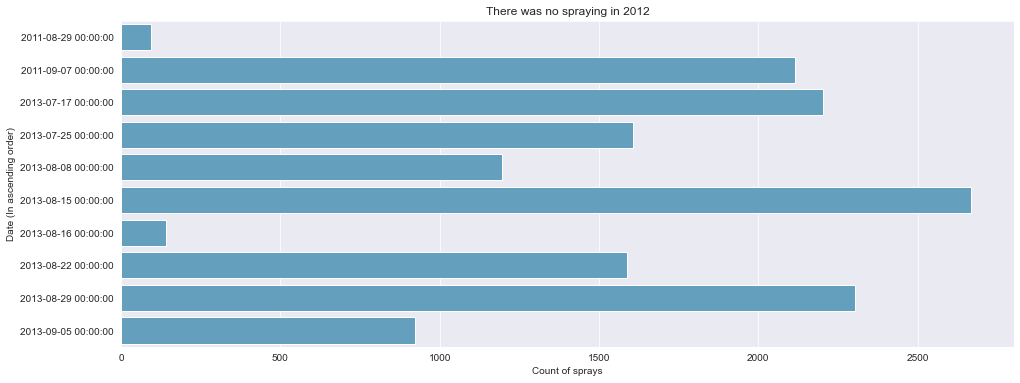

In [79]:
# Charting our time-series
plt.figure(figsize=(16, 6))
sns.barplot(y=spray_ts.index, x=spray_ts.values, color=sns.color_palette('icefire')[0])
plt.title("There was no spraying in 2012")
plt.xlabel("Count of sprays")
plt.ylabel("Date (In ascending order)")
plt.show()

In [81]:
# Filtering some outliers (We've realised this after plotting)
spray[['latitude', 'longitude']].describe()

,latitude,longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


In [82]:
# Removing sprays that occured outside of the parameters provided in the map
spray_filtered = spray.loc[spray['latitude'] < 42.1]

In [83]:
# Let's plot where sprays have been in the past
mapdata_txt = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata_txt.shape[0] * 1.0 / mapdata_txt.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

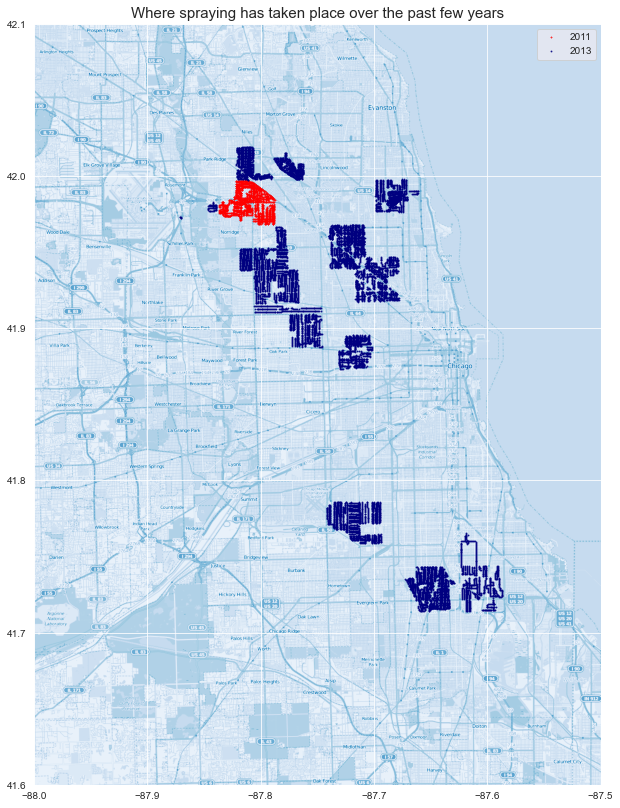

In [88]:
plt.figure(figsize=(14,14))
plt.imshow(mapdata_txt, cmap=plt.get_cmap('Blues_r'), extent=lon_lat_box, aspect=aspect)

spray_filtered["year"] = spray_filtered["date"].dt.year
spray_2011 = spray_filtered.loc[spray_filtered["year"]==2011]
spray_2013 = spray_filtered.loc[spray_filtered["year"]==2013]
spray_filtered.drop(["year"], axis=1, inplace=True)

spray_2011_chart = plt.scatter(spray_2011['longitude'], spray_2011['latitude'], 
                               c="red", marker='x', s=0.5, alpha=0.8, label ="2011")

spray_2013_chart = plt.scatter(spray_2013['longitude'], spray_2013['latitude'], 
                               c="navy", marker='o', s=0.5, alpha=0.8, label="2013")

plt.title("Where spraying has taken place over the past few years", fontsize=15)
plt.legend()
plt.show();

### Tidying our ```weather``` dataset

In [365]:
# Import our weather dataset
weather = pd.read_csv('../data/weather.csv')
weather.shape

(2944, 22)

In [366]:
# Converting our column names to lower-case for standardisation
weather.columns = weather.columns.str.lower()
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [367]:
# Previewing datatypes
weather.info()

# Once again, we'll need to convert the date column from an object to a datetime format
# We will need to convert a number of columns to int64 formats as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   station      2944 non-null   int64  
 1   date         2944 non-null   object 
 2   tmax         2944 non-null   int64  
 3   tmin         2944 non-null   int64  
 4   tavg         2944 non-null   object 
 5   depart       2944 non-null   object 
 6   dewpoint     2944 non-null   int64  
 7   wetbulb      2944 non-null   object 
 8   heat         2944 non-null   object 
 9   cool         2944 non-null   object 
 10  sunrise      2944 non-null   object 
 11  sunset       2944 non-null   object 
 12  codesum      2944 non-null   object 
 13  depth        2944 non-null   object 
 14  water1       2944 non-null   object 
 15  snowfall     2944 non-null   object 
 16  preciptotal  2944 non-null   object 
 17  stnpressure  2944 non-null   object 
 18  sealevel     2944 non-null   object 
 19  result

**Fixing our date column**

In [368]:
weather['date'] = pd.to_datetime(weather['date'], format="%Y-%m-%d")

**Replacing 'M' values in the dataset**

In [369]:
# Counting our missing values
weather[weather=='M'].count()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise           0
sunset            0
codesum           0
depth          1472
water1         2944
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
dtype: int64

**Trimming our dataset - Selecting columns of interest**

In [370]:
# Replacing all missing values with np.nan
weather[weather=='M'] = np.nan

XX

In [371]:
# See our reasonning above
cols_to_drop = ['depart', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'depth', 
                'water1', 'snowfall', 'resultspeed', 'resultdir']

In [372]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2933 non-null   object        
 5   depart       1472 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2940 non-null   object        
 8   heat         2933 non-null   object        
 9   cool         2933 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        1472 non-null   object        
 14  water1       0 non-null      object        
 15  snowfall     1472 non-null   object        
 16  precip

In [373]:
# Dropping unnecessary columns
weather.drop(columns=cols_to_drop, inplace=True)

**One-hot encoding ```codesum``` values**

In [374]:
weather['codesum'].unique()
# There's way too many unique values

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [375]:
# Ensuring there is proper spacing between different weather types
weather_codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL','IC', 'FG+', 'FG', 
                 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 
                 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']

weather['codesum'] = weather['codesum'].apply(lambda x: ' '.join([i for i in x.split(' ') if i in weather_codes]))

**We will need to create separate dummy variables for different conditions**

These include ```raining```,  ```snowing```,  ```windy```,  ```misty``` conditions

In [376]:
# Manual creation of dummy variables which rainy, snowy, windy and misty conditions 
weather["raining"] = np.where(weather['codesum'].str.contains("|".join(['TS', 'RA', 'DZ', 'SH'])), 1, 0)
weather["snowing"] = np.where(weather['codesum'].str.contains("|".join(['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'])), 1, 0)
weather["windy"] = np.where(weather['codesum'].str.contains("|".join(['SQ', 'DS', 'SS', 'PO', 'BL'])), 1, 0)
weather["misty"] = np.where(weather['codesum'].str.contains("|".join(['BR', 'HZ', 'FG', 'FU'])), 1, 0)

**Tidying / Fixing missing ```tavg``` values**

In [382]:
## We can manually inpute missing tavg values
weather['tavg'][weather['tavg'].isna()] = 0.5*(weather['tmax'][weather['tavg'].isna()] + weather['tmin'][weather['tavg'].isna()])

**Tidying / Fixing missing ```preciptotal``` values**

In [384]:
# We can manually inpute missing preciptotal
weather.loc[weather['preciptotal'].isna()]

,station,date,tmax,tmin,tavg,dewpoint,codesum,preciptotal,stnpressure,sealevel,avgspeed,raining,snowing,windy,misty
117,2,2007-06-28,73,61,67,56,,NaN,29.43,30.07,13.3,0,0,0,0
119,2,2007-06-29,71,56,64,56,,NaN,29.47,30.11,8.2,0,0,0,0


In [385]:
# Let's see how they stack up to their neighbours
weather.iloc[115:120,:]

,station,date,tmax,tmin,tavg,dewpoint,codesum,preciptotal,stnpressure,sealevel,avgspeed,raining,snowing,windy,misty
115,2,2007-06-27,89,71,80,69,RA BR,0.35,29.36,30.00,8.5,1,0,0,1
116,1,2007-06-28,74,58,66,55,,0.00,29.41,30.09,12.5,0,0,0,0
117,2,2007-06-28,73,61,67,56,,NaN,29.43,30.07,13.3,0,0,0,0
118,1,2007-06-29,70,56,63,55,,0.00,29.41,30.13,8.3,0,0,0,0
119,2,2007-06-29,71,56,64,56,,NaN,29.47,30.11,8.2,0,0,0,0


Based on the dataframe above, we can logically deduce that total precipitation will be a function of the weather type. Since we only have two missing values, we can logically impute them as 0 as there no significant weather types recorded on those days.

In [386]:
# We can safely assume that if the codesum does not indicate a significant weather type, we can assume preciptotal = 0
weather['preciptotal'] = [0 if i is np.nan else i for i in weather['preciptotal']]

**Tidying / Fixing ```preciptotal``` values that are recorded as 'T' (Trace amounts)**

In [387]:
# We can manually inpute missing preciptotal
weather.loc[weather['preciptotal'] == ("  T" or "T")]

,station,date,tmax,tmin,tavg,dewpoint,codesum,preciptotal,stnpressure,sealevel,avgspeed,raining,snowing,windy,misty
6,1,2007-05-04,66,49,58,41,RA,T,29.31,30.05,10.8,1,0,0,0
8,1,2007-05-05,66,53,60,38,,T,29.40,30.10,12.0,0,0,0,0
9,2,2007-05-05,66,54,60,39,,T,29.46,30.09,11.5,0,0,0,0
12,1,2007-05-07,83,47,65,41,RA,T,29.38,30.12,10.5,1,0,0,0
15,2,2007-05-08,80,60,70,57,HZ,T,29.36,30.02,5.4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2,2014-10-16,58,53,56,52,DZ BR,T,29.09,29.77,8.4,1,0,0,1
2914,1,2014-10-17,62,48,55,46,,T,28.99,29.69,13.2,0,0,0,0
2927,2,2014-10-23,62,41,52,41,BR,T,29.46,30.16,8.4,0,0,0,1
2936,1,2014-10-28,68,45,57,38,,T,29.15,29.85,15.6,0,0,0,0


In [388]:
# We can safely assume that if the codesum does not indicate a significant weather type, we can assume preciptotal = 0
weather['preciptotal'] = [np.nan if i in ["T", "  T"] else i for i in weather['preciptotal']]

In [389]:
## Let's tidy lot_frontage using the median corresponding to the dataset
imputed_precip_total = {}
for i in weather['codesum'].unique():
    imputed_precip_total[i] = weather[weather['codesum'] == i]['preciptotal'].median()

In [390]:
# We can imput the precipitation total by using the median values from different weather conditions
weather['preciptotal'][weather['preciptotal'].isnull()] = weather['codesum'][weather['preciptotal'].isnull()].map(imputed_precip_total)

In [391]:
weather['preciptotal'][weather['preciptotal'].isna()] = 0

**Tidying / Fixing missing ```stnpressure``` values**

In [392]:
## Let's tidy lot_frontage using the median corresponding to the dataset
imputed_stnpressure = {}
for i in weather['station'].unique():
    imputed_stnpressure[i] = weather[weather['station'] == i]['stnpressure'].median()

In [393]:
# We can imput the precipitation total by using the median values from different weather conditions
weather['stnpressure'][weather['stnpressure'].isna()] = weather['station'][weather['stnpressure'].isna()].map(imputed_stnpressure)

**Tidying / Fixing missing ```sealevel``` values**

In [394]:
imputed_sealevel = {}
for i in weather['station'].unique():
    imputed_sealevel[i] = weather[weather['station'] == i]['sealevel'].median()

In [395]:
# We can imput the precipitation total by using the median values from different weather conditions
weather['sealevel'][weather['sealevel'].isna()] = weather['station'][weather['sealevel'].isna()].map(imputed_stnpressure)

**Tidying / Fixing missing ```avgspeed``` values**

In [396]:
## Let's tidy lot_frontage using the median corresponding to the dataset
imputed_avgspeed = {}
for i in weather['codesum'].unique():
    imputed_avgspeed[i] = weather[weather['codesum'] == i]['avgspeed'].median()

In [397]:
# We can imput the precipitation total by using the median values from different weather conditions
weather['avgspeed'][weather['avgspeed'].isna()] = weather['codesum'][weather['avgspeed'].isna()].map(imputed_avgspeed)

**Ensuring datatypes are representative**

In [398]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   dewpoint     2944 non-null   int64         
 6   codesum      2944 non-null   object        
 7   preciptotal  2944 non-null   object        
 8   stnpressure  2944 non-null   object        
 9   sealevel     2944 non-null   object        
 10  avgspeed     2944 non-null   object        
 11  raining      2944 non-null   int32         
 12  snowing      2944 non-null   int32         
 13  windy        2944 non-null   int32         
 14  misty        2944 non-null   int32         
dtypes: datetime64[ns](1), int32(4), int64(4), object(6)
mem

In [406]:
weather[['tavg', 'preciptotal', 'stnpressure', 
         'sealevel', 'avgspeed']] = weather[['tavg', 'preciptotal', 
                                             'stnpressure', 'sealevel', 'avgspeed']].astype(float)

In [407]:
# Dropping our codesum column now that we have our one-hot encoded-variables
weather.drop(columns='codesum', inplace=True)

In [410]:
weather['humidity'] = 100*(np.exp((17.67 * ((weather['dewpoint'] - 32) * (5/9))) / 
                                           (243.5 + ((weather['dewpoint'] - 32) * (5/9)))) 
                                    /
                                    np.exp((17.67 * ((weather['tavg'] - 32) * (5/9))) /
                                           (243.5 + ((weather['tavg'] - 32) * (5/9)))))

In [411]:
# Previewing our final dataframe
weather.head()

,station,date,tmax,tmin,tavg,dewpoint,preciptotal,stnpressure,sealevel,avgspeed,raining,snowing,windy,misty,humidity
0,1,2007-05-01,83,50,67.0,51,0.0,29.10,29.82,67.0,0,0,0,0,56.410238
1,2,2007-05-01,84,52,68.0,51,0.0,29.18,29.82,68.0,0,0,0,0,54.497276
2,1,2007-05-02,59,42,51.0,42,0.0,29.38,30.09,51.0,0,0,0,1,71.176939
3,2,2007-05-02,60,43,52.0,42,0.0,29.44,30.08,52.0,0,0,0,1,68.594699
4,1,2007-05-03,66,46,56.0,40,0.0,29.39,30.12,56.0,0,0,0,0,54.848860


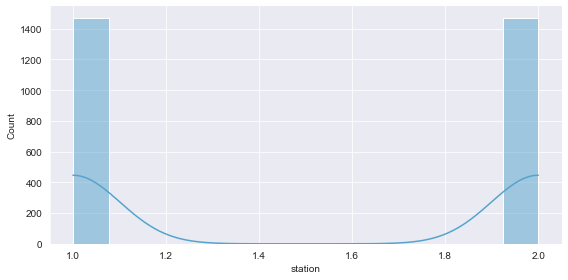

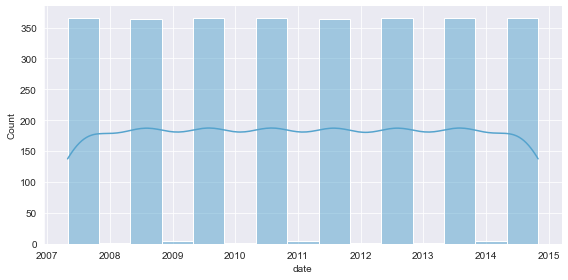

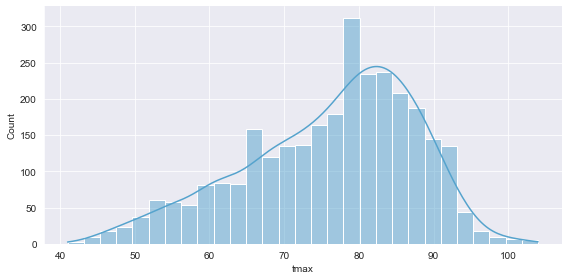

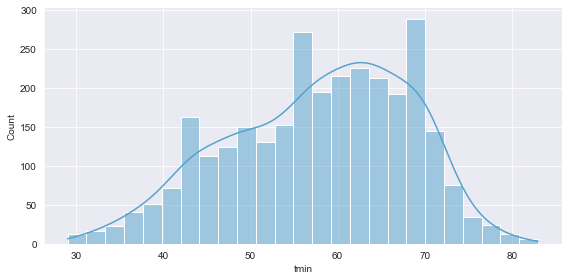

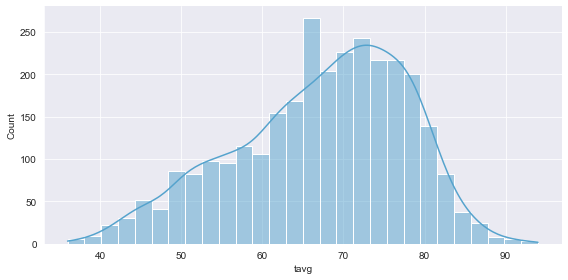

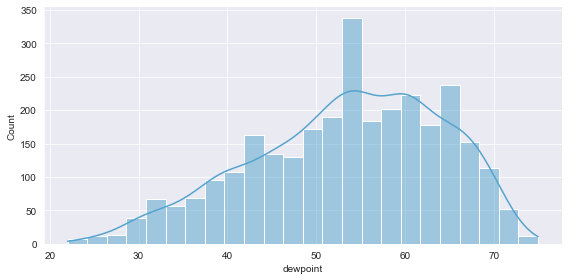

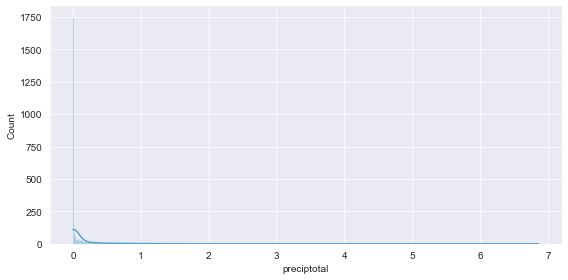

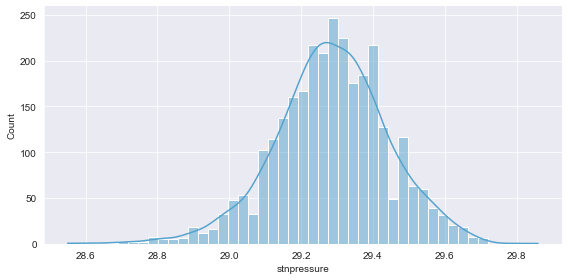

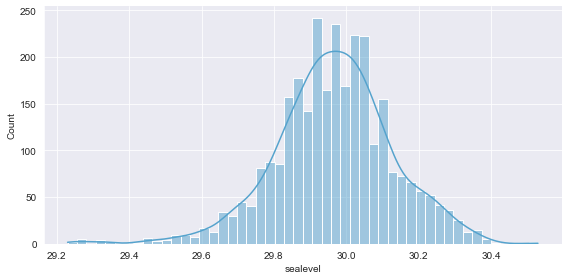

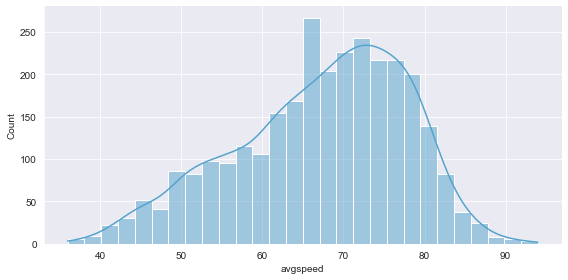

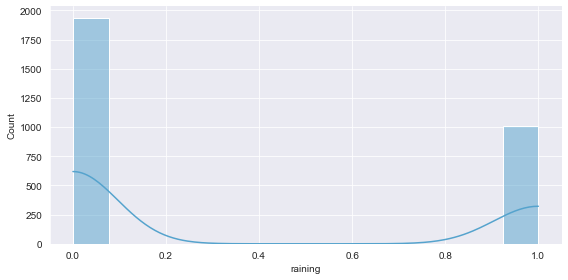

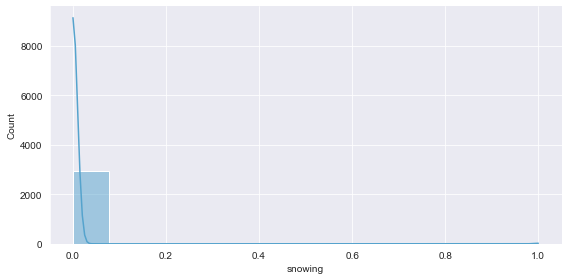

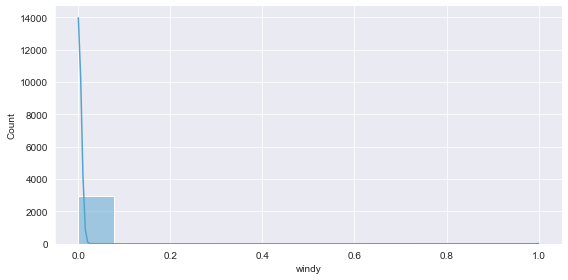

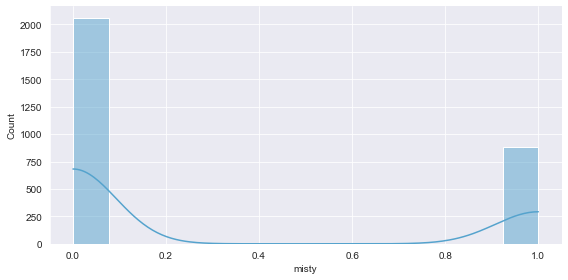

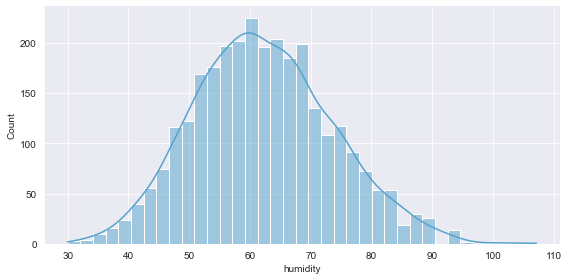

In [416]:
# Let's take a quick look at the distributions of our varibles
for i in weather.columns:
    sns.displot(x=weather[i], kde=True, aspect=2, height=4)
    plt.show()